In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *

def spspmm(A,B):
    return torch.sparse.mm(A,B)

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
lat_min = 32
lat_max = 44

datadir="/dmidata/users/maxb/NATL_dataset"
datamodule = BaseDataModule(input_da=load_altimetry_data(datadir+"/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 16, 'num_workers': 1},
                            grad=False,
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

KeyboardInterrupt: 

# Define the solver

In [ ]:
### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GradSolver(nn.Module):
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2, reset_state=True, **kwargs):
        super().__init__()
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod

        self.n_step = n_step
        self.lr_grad = lr_grad

        self._grad_norm = None
        self.reset_state = reset_state

    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init
        return torch.randn(batch.tgt.size(),device=device).detach().requires_grad_(True)
        #return batch.input.nan_to_num().detach().requires_grad_(True)

    def solver_step(self, state, batch, step):
        var_cost = self.prior_cost(state) + self.obs_cost(state, batch)
        grad = torch.autograd.grad(var_cost, state, create_graph=True)[0]

        gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )

        return state - state_update

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            if self.reset_state:
                self.grad_mod.reset_state(batch.input)

            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                if not self.training:
                    state = state.detach().requires_grad_(True)

            #if not self.training:
            #    state = self.prior_cost.forward_ae(state)
            #state = self.prior_cost.forward_ae(state)
        return state


class ConvLstmGradModel(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, dropout=0.1, downsamp=None):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.gates = torch.nn.Conv2d(
            dim_in + dim_hidden,
            4 * dim_hidden,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )

        self.conv_out = torch.nn.Conv2d(
            dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.dropout = torch.nn.Dropout(dropout)
        self._state = []
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def reset_state(self, inp):
        size = [inp.shape[0], self.dim_hidden, *inp.shape[-2:]]
        self._grad_norm = None
        self._state = [
            self.down(torch.zeros(size, device=inp.device)),
            self.down(torch.zeros(size, device=inp.device)),
        ]

    def forward(self, x):
        if self._grad_norm is None:
            self._grad_norm = (x**2).mean().sqrt()
        x =  x / self._grad_norm
        hidden, cell = self._state
        x = self.dropout(x)
        x = self.down(x)
        gates = self.gates(torch.cat((x, hidden), 1))

        in_gate, remember_gate, out_gate, cell_gate = gates.chunk(4, 1)

        in_gate, remember_gate, out_gate = map(
            torch.sigmoid, [in_gate, remember_gate, out_gate]
        )
        cell_gate = torch.tanh(cell_gate)

        cell = (remember_gate * cell) + (in_gate * cell_gate)
        hidden = out_gate * torch.tanh(cell)

        self._state = hidden, cell
        out = self.conv_out(hidden)
        out = self.up(out)
        return out

class BaseObsCost(nn.Module):
    def __init__(self, w=1) -> None:
        super().__init__()
        self.w=w

    def forward(self, state, batch):
        msk = batch.input.isfinite()
        return self.w * F.mse_loss(state[msk], batch.input.nan_to_num()[msk])

class BilinAEPriorCost(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad=True, nt=None):
        super().__init__()
        self.nt = nt
        self.bilin_quad = bilin_quad
        self.conv_in = nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.bilin_1 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.conv_out = nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def forward_ae(self, x):
        x = self.down(x)
        x = self.conv_in(x)
        x = self.conv_hidden(F.relu(x))

        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )
        x = self.up(x)
        return x

    def forward(self, state, exclude_params=False):
        if not exclude_params:
            return F.mse_loss(state, self.forward_ae(state))
        else:
            return F.mse_loss(state[:,:self.nt,:,:], self.forward_ae(state)[:,:self.nt,:,:])

In [ ]:
device = 'cuda'

# state only
solver = GradSolver(n_step=15,
                    lr_grad=1e-3,
                    prior_cost = BilinAEPriorCost(dim_in=9,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                    obs_cost = BaseObsCost(),
                    grad_mod = ConvLstmGradModel(dim_in=9,dim_hidden=96)).to(device)

# Training (disjoint)

In [5]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    prior_cost = solver.prior_cost(solver.init_state(batch, out))
    training_loss = 50*loss  + 10000 * grad_loss + 10 * prior_cost
    print(50*loss, 10000 * grad_loss, 10 * prior_cost)
    
    return training_loss, out

def base_step(batch):

    out = solver(batch=batch).to(device)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  50#@param {'type':'integer'}
lr = 1e-3 #@param {'type':'number'}
    
optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
        ])

start = 0
reload = False
if reload:

    ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2.pth', map_location=device)
    solver.load_state_dict(ckpt)

tqdm_epoch = tqdm(range(start,start+n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    batch = batch._replace(input=(batch.input).nan_to_num().to(device))
    batch = batch._replace(tgt=(batch.tgt).to(device))
    loss, out = step(batch)
    optimizer.zero_grad() 
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)
    clear_output(wait=True)
    
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5)) 
  gt = ax1.imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(gt, ax=ax1)
  inp = ax2.imshow(batch.input[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(inp, ax=ax2)
  inp = ax3.imshow(out[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5) 
  plt.colorbar(inp, ax=ax3)
  plt.show()
    
  # Update the checkpoint after each epoch of training.
  torch.save(solver.state_dict(), '../ckpt/ckpt_base.pth')

tensor(3.9941, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(35.8135, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.9569, device='cuda:0', grad_fn=<MulBackward0>)
tensor(40.7645, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


# Test of the model

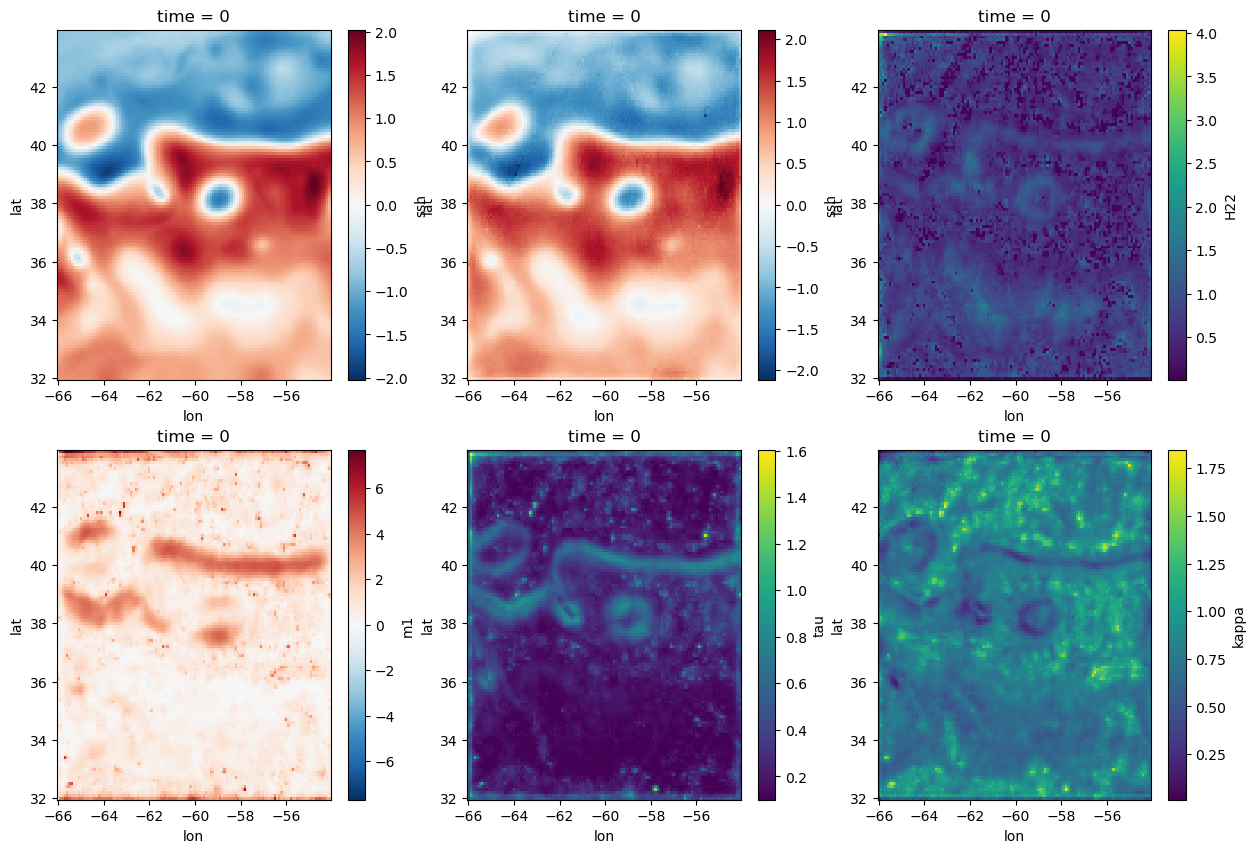

In [8]:
# test
from IPython.display import clear_output
ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2.pth', map_location=device)
solver2.load_state_dict(ckpt)
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2.pth', map_location=device)
solver.load_state_dict(ckpt)

k = 2
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))

test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

out = solver2(test_batch)
cropped_batch = crop_batch(test_batch)
# provide mu as coarse version of 4DVarNet outputs
mean = up(down(out))
cropped_batch = cropped_batch._replace(input=test_batch.tgt[:,crop_daw//2:-(crop_daw//2),:,:].to(device)) #
out_spde, theta = solver(batch=cropped_batch, 
                    #x_init=out[:,crop_daw//2:-(crop_daw//2),:,:].detach(),
                    #mu=mean[:,crop_daw//2:-(crop_daw//2),:,:].detach())
                    x_init=test_batch.tgt[:,crop_daw//2:-(crop_daw//2),:,:].detach(),
                    mu=out[:,crop_daw//2:-(crop_daw//2),:,:].detach())
out = out[:,crop_daw//2:-(crop_daw//2),:,:]#
if not out_as_first_guess:
    out = out_spde

fig, axs= plt.subplots(2, 3, figsize=(15,10)) 
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[:,idt1,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.isel(time=0).plot(ax=axs[0,0])#(col='time')
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[:,idt2,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.isel(time=0).plot(ax=axs[0,1])#(col='time')